In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Algorithms

#### k-means

In [2]:
class Kmeans:
    """K-Means Clustering Algorithm"""
    
    def __init__(self, k, centers=None, cost=None,iter=None, labels=None, max_iter = 1000):
        """Initialize Parameters"""
        
        self.max_iter = max_iter
        self.k = k
        self.centers = np.empty(1)
        self.cost = []
        self.iter = 1
        self.labels = np.empty(1)

    def calc_distances(self, data, centers, weights):
        """Distance Matrix"""
        
        distance = pairwise_distances(data, centers)**2
        min_distance = np.min(distance, axis = 1)
        D = min_distance*weights
        return D    
    
    def fit(self, data):
        """Clustering Process"""
        
        ## Initial centers
        if type(data) == pd.DataFrame: data = data.values
        nrow = data.shape[0]
        index = np.random.choice(range(nrow), self.k, False)
        self.centers = data[index]
        
        while (self.iter <= self.max_iter):
            distance = pairwise_distances(data, self.centers)**2
            self.cost.append(sum(np.min(distance, axis=1)))
            self.labels = np.argmin(distance, axis=1)
            centers_new = np.array([np.mean(data[self.labels == i], axis=0) for i in np.unique(self.labels)])
            
            ## sanity check
            if(np.all(self.centers == centers_new)): break 
            self.centers = centers_new
            self.iter += 1
            
        ## convergence check
        if (sum(np.min(pairwise_distances(data, self.centers)**2, axis=1)) != self.cost[-1]):
            warnings.warn("Algorithm Did Not Converge In {} Iterations".format(self.max_iter))
        return self

#### K-Means++

In [3]:
class Kmeanspp:
    """K-Means++ Clustering Algorithm"""
    
    def __init__(self, k, centers=None, cost=None,iter=None, labels=None, max_iter = 1000):
        """Initialize Parameters"""
        
        self.max_iter = max_iter
        self.k = k
        self.centers = np.empty(1)
        self.cost = []
        self.iter = 1
        self.labels = np.empty(1)

    def calc_distances(self, data, centers, weights):
        """Distance Matrix"""
        
        distance = pairwise_distances(data, centers)**2
        min_distance = np.min(distance, axis = 1)
        D = min_distance*weights
        return D
    
    def initial_centers_Kmeansapp(self, data, k, weights):
        """Initialize centers for K-Means++"""
        
        centers = []
        centers.append(random.choice(data))
        while(len(centers) < k):   
            distances = self.calc_distances(data, centers, weights)
            prob = distances/sum(distances)
            c = np.random.choice(range(data.shape[0]), 1, p=prob)
            centers.append(data[c[0]])
        return centers
    

    def fit(self, data, weights=None):
        """Clustering Process"""
        
        if weights is None: weights = np.ones(len(data))
        if type(data) == pd.DataFrame: data=data.values
        nrow = data.shape[0]
        self.centers = self.initial_centers_Kmeansapp(data, self.k, weights)
        
        while (self.iter <= self.max_iter):
            distance = pairwise_distances(data, self.centers)**2
            self.cost.append(sum(np.min(distance, axis=1)))
            self.labels = np.argmin(distance, axis=1)
            centers_new = np.array([np.mean(data[self.labels == i], axis=0) for i in np.unique(self.labels)])
            
            ## sanity check
            if(np.all(self.centers == centers_new)): break 
            self.centers = centers_new
            self.iter += 1
        
        ## convergence check
        if (sum(np.min(pairwise_distances(data, self.centers)**2, axis=1)) != self.cost[-1]):
            warnings.warn("Algorithm Did Not Converge In {} Iterations".format(self.max_iter))
        return self

#### K-Meansll

In [4]:
class Kmeansll:
    """K-Meansll Clustering Algorithm"""
    
    def __init__(self, k, omega, centers=None, cost=None,iter=None, labels=None, max_iter = 1000):
        """Initialize Parameters"""
        
        self.max_iter = max_iter
        self.k = k
        self.omega = omega
        self.centers = np.empty(1)
        self.cost = []
        self.iter = 1
        self.labels = np.empty(1)
        
    def calc_weight(self, data, centers):
        """Weight Calculation"""
        
        l = len(centers)
        distance = pairwise_distances(data, centers)
        labels = np.argmin(distance, axis=1)
        weights = [sum(labels == i) for i in range(l)]
        return (weights/sum(weights))

    def calc_distances(self, data, centers, weights):
        """Distance Matrix"""
        
        distance = pairwise_distances(data, centers)**2
        min_distance = np.min(distance, axis = 1)
        D = min_distance*weights
        return D
    
    def initial_centers_Kmeansll(self, data, k, omega, weights):    
        """Initialize Centers for K-Meansll"""
        
        centers = []
        centers.append(random.choice(data))
        phi = np.int(np.round(np.log(sum(self.calc_distances(data, centers, weights)))))
        l = k*omega ## oversampling factor
        for i in range(phi):
            dist = self.calc_distances(data, centers, weights)
            prob = l*dist/sum(dist)
            for i in range(len(prob)):
                if prob[i] > np.random.uniform():
                    centers.append(data[i])
        centers = np.array(centers)
        recluster_weight = self.calc_weight(data, centers)
        reclusters = Kmeanspp(k).fit(centers, recluster_weight).labels
        initial_centers = []
        for i in np.unique(reclusters):
            initial_centers.append(np.mean(centers[reclusters == i], axis = 0))
        return initial_centers
    
    
    def fit(self, data, weights=None):
        """Clustering Process"""
        
        if weights is None: weights = np.ones(len(data))
        if type(data) == pd.DataFrame: data=data.values
        nrow = data.shape[0]
        self.centers = self.initial_centers_Kmeansll(data, self.k, self.omega, weights)
        while (self.iter <= self.max_iter):
            distance = pairwise_distances(data, self.centers)**2
            self.cost.append(sum(np.min(distance, axis=1)))
            self.labels = np.argmin(distance, axis=1)
            centers_new = np.array([np.mean(data[self.labels == i], axis=0) for i in np.unique(self.labels)])
            
            ## sanity check
            if(np.all(self.centers == centers_new)): break 
            self.centers = centers_new
            self.iter += 1
        
        ## convergence check
        if (sum(np.min(pairwise_distances(data, self.centers)**2, axis=1)) != self.cost[-1]):
            warnings.warn("Algorithm Did Not Converge In {} Iterations".format(self.max_iter))
        return self

### Function Comparison

In [5]:
def Kmeans_manu(data, k, max_iter = 1000):
    
    """This function implements the K-Means Algorith"""
    
    if type(data) == pd.DataFrame: data = data.values
    
    nrow = data.shape[0]
    index = np.random.choice(range(nrow), k, False)
    centers = data[index]
    cost = []
    iter = 1
    
    while (iter <= max_iter):
        distance = np.zeros([nrow, len(centers)])
        ## calculate distance & labels
        for i in range(nrow):
            for j in range(len(centers)):
                distance[i,j] = np.linalg.norm(data[i] - centers[j])**2        
        cost.append(sum(np.min(distance, axis=1)))
        labels = np.argmin(distance, axis=1)
        
        ## update centers
        centers_new = np.array([np.mean(data[labels == i], axis=0) for i in np.unique(labels)])
        
        ## sanity check
        if(np.all(centers == centers_new)): break 
        centers = centers_new
        iter += 1
    
    return labels, cost, iter, centers

In [6]:
spam = pd.read_csv("spambase.data", header = None).values

In [7]:
%timeit Kmeans(5).fit(spam)
%timeit Kmeans_manu(spam, 5)

146 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.81 s ± 636 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Simulation

In [8]:
cluster1 = np.c_[np.random.normal(1, 0.5, 1000), np.random.normal(2, 0.5, 1000)]
cluster2 = np.c_[np.random.normal(6, 0.5, 1000), np.random.normal(3, 0.5, 1000)]
cluster3 = np.c_[np.random.normal(3, 0.5, 1000), np.random.normal(5, 0.5, 1000)]
cluster4 = np.c_[np.random.normal(4, 0.5, 1000), np.random.normal(0, 0.5, 1000)]
cluster5 = np.c_[np.random.normal(3.5, 0.5, 500), np.random.normal(2, 0.5, 500)]
simulation = np.r_[cluster1, cluster2, cluster3, cluster4, cluster5]

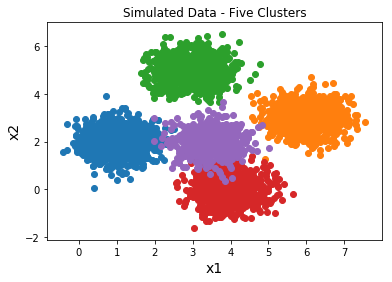

In [9]:
plt.scatter(cluster1[:,0], cluster1[:,1])
plt.scatter(cluster2[:,0], cluster2[:,1])
plt.scatter(cluster3[:,0], cluster3[:,1])
plt.scatter(cluster4[:,0], cluster4[:,1])
plt.scatter(cluster5[:,0], cluster5[:,1])
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("Simulated Data - Five Clusters")
pass

#### K-Means

In [10]:
k1 = Kmeans(5).fit(simulation)
labels1, cost1, iter1, centers1 = k1.labels, k1.cost, k1.iter, k1.centers

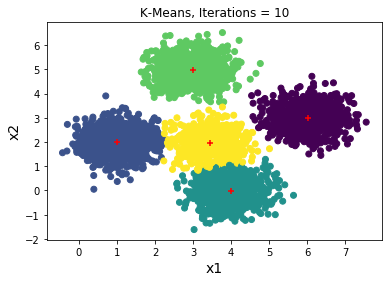

In [11]:
plt.scatter(simulation[:,0], simulation[:,1], c=labels1)
plt.scatter(centers1[0][0], centers1[0][1], c="red", marker="+")
plt.scatter(centers1[1][0], centers1[1][1], c="red", marker="+")
plt.scatter(centers1[2][0], centers1[2][1], c="red", marker="+")
plt.scatter(centers1[3][0], centers1[3][1], c="red", marker="+")
plt.scatter(centers1[4][0], centers1[4][1], c="red", marker="+")
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("K-Means, Iterations = {}".format(iter1))
pass

#### K-Means ++

In [13]:
k2 = Kmeanspp(5).fit(simulation)
labels2, cost2, iter2, centers2 = k2.labels, k2.cost, k2.iter, k2.centers

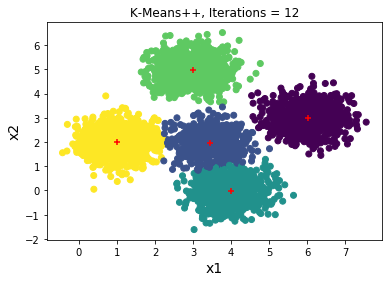

In [14]:
plt.scatter(simulation[:,0], simulation[:,1], c=labels2)
plt.scatter(centers2[0][0], centers2[0][1], c="red", marker="+")
plt.scatter(centers2[1][0], centers2[1][1], c="red", marker="+")
plt.scatter(centers2[2][0], centers2[2][1], c="red", marker="+")
plt.scatter(centers2[3][0], centers2[3][1], c="red", marker="+")
plt.scatter(centers2[4][0], centers2[4][1], c="red", marker="+")
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("K-Means++, Iterations = {}".format(iter2))
pass

#### K-Means ll

In [15]:
k3 = Kmeansll(5, 0.5).fit(simulation)
labels3, cost3, iter3, centers3 = k3.labels, k3.cost, k3.iter, k3.centers

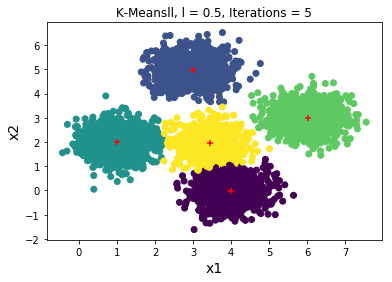

In [18]:
plt.scatter(simulation[:,0], simulation[:,1], c=labels3)
plt.scatter(centers3[0][0], centers3[0][1], c="red", marker="+")
plt.scatter(centers3[1][0], centers3[1][1], c="red", marker="+")
plt.scatter(centers3[2][0], centers3[2][1], c="red", marker="+")
plt.scatter(centers3[3][0], centers3[3][1], c="red", marker="+")
plt.scatter(centers3[4][0], centers3[4][1], c="red", marker="+")
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("K-Meansll, l = 0.5, Iterations = {}".format(iter3))
pass

In [19]:
k4 = Kmeansll(5, 1).fit(simulation)
labels4, cost4, iter4, centers4 = k4.labels, k4.cost, k4.iter, k4.centers

In [20]:
k5 = Kmeansll(5, 2).fit(simulation)
labels5, cost5, iter5, centers5 = k5.labels, k5.cost, k5.iter, k5.centers

#### Cost v.s. Iteration Plot

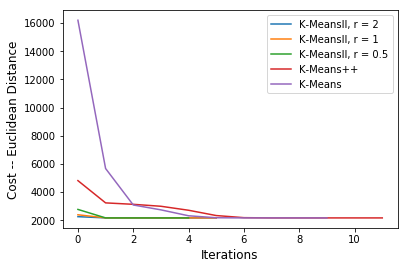

In [21]:
plt.plot(cost5)
plt.plot(cost4)
plt.plot(cost3)
plt.plot(cost2)
plt.plot(cost1)
plt.legend(("K-Meansll, r = 2","K-Meansll, r = 1","K-Meansll, r = 0.5", "K-Means++", "K-Means"))
plt.xlabel("Iterations", fontsize = 12)
plt.ylabel("Cost -- Euclidean Distance", fontsize = 12)
pass

In [22]:
%timeit Kmeans(5).fit(simulation)
%timeit Kmeanspp(5).fit(simulation)
%timeit Kmeansll(5, 0.5).fit(simulation)
%timeit Kmeansll(5, 1).fit(simulation)
%timeit Kmeansll(5, 2).fit(simulation)

18.8 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.9 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
356 ms ± 48.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
546 ms ± 90.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.03 s ± 92.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Real-World Data
#### Spam Data
https://archive.ics.uci.edu/ml/datasets/Spambase

In [24]:
spam = pd.read_csv("spambase.data", header = None).values

#### K-Means

In [34]:
k1 = Kmeans(5).fit(spam)
labels1, cost1, iter1, centers1 = k1.labels, k1.cost, k1.iter, k1.centers

#### K-Means++

In [35]:
k2 = Kmeanspp(5).fit(spam)
labels2, cost2, iter2, centers2 = k2.labels, k2.cost, k2.iter, k2.centers

#### K-Meansll

In [36]:
k3 = Kmeansll(5, 0.5).fit(spam)
labels3, cost3, iter3, centers3 = k3.labels, k3.cost, k3.iter, k3.centers

In [37]:
k4 = Kmeansll(5, 1).fit(spam)
labels4, cost4, iter4, centers4 = k4.labels, k4.cost, k4.iter, k4.centers

In [38]:
k5 = Kmeansll(5, 2).fit(spam)
labels5, cost5, iter5, centers5 = k5.labels, k5.cost, k5.iter, k5.centers

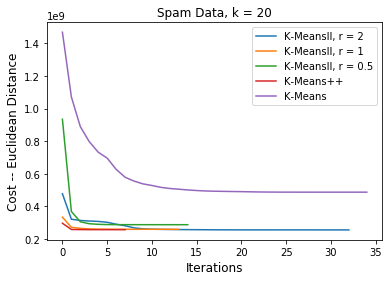

In [39]:
plt.plot(cost5)
plt.plot(cost4)
plt.plot(cost3)
plt.plot(cost2)
plt.plot(cost1)
plt.legend(("K-Meansll, r = 2","K-Meansll, r = 1","K-Meansll, r = 0.5", "K-Means++", "K-Means"))
plt.xlabel("Iterations", fontsize = 12)
plt.ylabel("Cost -- Euclidean Distance", fontsize = 12)
plt.title("Spam Data, k = 20")
pass

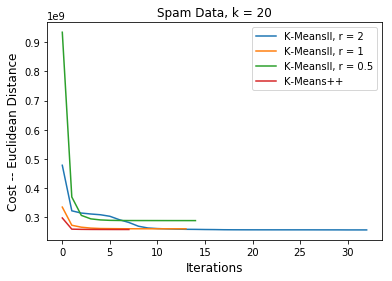

In [40]:
plt.plot(cost5)
plt.plot(cost4)
plt.plot(cost3)
plt.plot(cost2)
plt.legend(("K-Meansll, r = 2","K-Meansll, r = 1","K-Meansll, r = 0.5", "K-Means++"))
plt.xlabel("Iterations", fontsize = 12)
plt.ylabel("Cost -- Euclidean Distance", fontsize = 12)
plt.title("Spam Data, k = 20")
pass

In [41]:
%timeit Kmeans(20).fit(spam)
%timeit Kmeanspp(20).fit(spam)
%timeit Kmeansll(20, 0.5).fit(spam)
%timeit Kmeansll(20, 1).fit(spam)
%timeit Kmeansll(20, 2).fit(spam)

827 ms ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
237 ms ± 76.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.2 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.12 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.94 s ± 538 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit Kmeans(50).fit(spam)
%timeit Kmeanspp(50).fit(spam)
%timeit Kmeansll(50, 0.5).fit(spam)
%timeit Kmeansll(50, 1).fit(spam)
%timeit Kmeansll(50, 2).fit(spam)

1.16 s ± 333 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
398 ms ± 70 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.15 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.7 s ± 347 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.8 s ± 934 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%timeit Kmeans(50).fit(spam)
%timeit Kmeanspp(50).fit(spam)
%timeit Kmeansll(50, 0.5).fit(spam)
%timeit Kmeansll(50, 1).fit(spam)
%timeit Kmeansll(50, 2).fit(spam)

966 ms ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
388 ms ± 75.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.55 s ± 306 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.54 s ± 380 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.2 s ± 1.67 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
